# Features engineering <font style="font-size:.5em">_• Daily Weather Observations_</font>

In [1]:
# imports, conf. & base dataset (df)
import os
import sys
sys.path.insert(0, os.path.abspath("../lib"))

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

sns.set(rc={"figure.dpi":72, 'savefig.dpi':200})
sns.set_theme(font_scale=1.25)

from ozpydry.display import md
from ozpydry.metrics import ClfReport
from ozpydry.model_selection import sample_tts

# Load dataset
from ozpydry.model_selection import load_df
df = load_df()

## Samples balancing
_The naive attempt_

Notre première approche sera de tester quelques modèles "simples" sur un jeu de données réduit équilibré / non équilibré (état par défaut). Nous évitons ainsi des temps de calculs coûteux.

Nous mettrons ensuite en lumière les features à retenir par l'interpretation de modèles comparés aux conclusions formulées dans le rapport d'exploration.

In [3]:
# Testing un/balanced data on KNeighbors classifier
from sklearn.neighbors import KNeighborsClassifier

report = ClfReport('./reports/balancing-report')

# KNClassifier(k=5) unbalanced
Xs, Xt, ys, yt = sample_tts()
knc = KNeighborsClassifier()
knc.fit(Xs, ys)
report(knc, (Xs, Xt, ys, yt), "KNClassifier(k=5)", False)

# KNClassifier(k=5) balanced (undersampled)
Xs, Xt, ys, yt = sample_tts('under')
knc = KNeighborsClassifier()
knc.fit(Xs, ys)
report(knc, (Xs, Xt, ys, yt), "KNClassifier(k=5) undersampled", False)

# KNClassifier(k=5) balanced (oversampled)
Xs, Xt, ys, yt = sample_tts('over')
knc = KNeighborsClassifier()
knc.fit(Xs, ys)
report(knc, (Xs, Xt, ys, yt), "KNClassifier(k=5) oversampled", False)

report.show()

<div class="rt">

|||pre|rec|spe|f1|geo|iba|sup|
|-|-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
|KNClassifier(k=5)|||||||||
|_78% balance_|0|0.93|0.87|0.69|0.90|0.78|0.61|9404|
|_22% balance_|1|0.52|0.69|0.87|0.60|0.78|0.59|1880|
||avg / total|0.87|0.84|0.72|0.85|0.78|0.61||
||test accuracy||||0.84||||
||train accuracy||||0.88||||
|KNClassifier(k=5) undersampled|||||||||
|_50% balance_|0|0.78|0.92|0.50|0.85|0.68|0.48|7419|
|_50% balance_|1|0.77|0.50|0.92|0.61|0.68|0.44|3865|
||avg / total|0.78|0.78|0.64|0.76|0.68|0.47||
||test accuracy||||0.78||||
||train accuracy||||0.85||||
|KNClassifier(k=5) oversampled|||||||||
|_50% balance_|0|0.78|0.91|0.48|0.84|0.66|0.46|7478|
|_50% balance_|1|0.74|0.48|0.91|0.58|0.66|0.42|3806|
||avg / total|0.76|0.77|0.63|0.75|0.66|0.45||
||test accuracy||||0.77||||
||train accuracy||||0.90||||

</div>
        <style>
            .rt { color:#444; }
            .rt th, .rt td { border:none; border-bottom: 1px solid lightgrey; }
            .rt tr:nth-child(6n+1) {color:black;}
            .rt th + th, .rt td + td { border-right: 4px solid white; }
            .rt tr:first-child th + th + th { font-weight:normal;color:black;border-bottom-color:#888; }
        </style>
        

#### Note

Sans recherche des hyper-paramètres optimaux, le jeu de données non équilibré donne un résulat plus homogène pour la classe sous-peuplée (cf. précision, recall et geometric mean). Le re-échantillonage semble tendre vers un overfitting et déséquilibre la précision et le recall de la classe minoritaire. Nous poursuivons donc en conservant le déséquilibre du jeu de données.

## Features exploration

Nous entrainons une régression logistique et un arbre de décision. Ces deux classifieurs vont nous servir à visualiser l'importance attribuée à chacune des variables explicatives.

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler

report = ClfReport('./reports/feature-sel-report')

# fit logistic regression with normalized data
Xs, Xt, ys, yt = sample_tts()
sc = StandardScaler()
Xs = sc.fit_transform(Xs) # keep feature names
Xt = sc.transform(Xt)
lrg = LogisticRegression(max_iter=200)
lrg.fit(Xs, ys)
report(lrg, (Xs, Xt, ys, yt), 'LogiticReg (minmax norm.)', False)

# fit a decision tree with discretised categorials
Xs, Xt, ys, yt = sample_tts(encode='discrete')
dtc = DecisionTreeClassifier(max_depth=10)
dtc.fit(Xs, ys)
report(dtc, (Xs, Xt, ys, yt), 'DecisionTree(d=10)', False)

report.show()

<div class="rt">

|||pre|rec|spe|f1|geo|iba|sup|
|-|-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
|LogiticReg (minmax norm.)|||||||||
|_78% balance_|0|0.95|0.88|0.74|0.91|0.81|0.66|9478|
|_22% balance_|1|0.54|0.74|0.88|0.62|0.81|0.64|1806|
||avg / total|0.88|0.86|0.76|0.87|0.81|0.66||
||test accuracy||||0.86||||
||train accuracy||||0.86||||
|DecisionTree(d=10)|||||||||
|_78% balance_|0|0.93|0.87|0.68|0.90|0.77|0.60|9487|
|_22% balance_|1|0.49|0.68|0.87|0.57|0.77|0.58|1797|
||avg / total|0.86|0.84|0.71|0.85|0.77|0.60||
||test accuracy||||0.84||||
||train accuracy||||0.89||||

</div>
        <style>
            .rt { color:#444; }
            .rt th, .rt td { border:none; border-bottom: 1px solid lightgrey; }
            .rt tr:nth-child(6n+1) {color:black;}
            .rt th + th, .rt td + td { border-right: 4px solid white; }
            .rt tr:first-child th + th + th { font-weight:normal;color:black;border-bottom-color:#888; }
        </style>
        

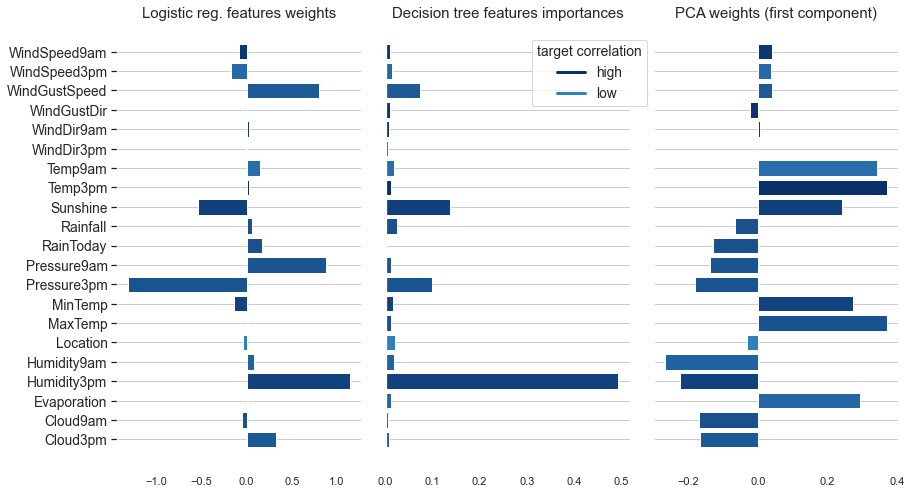

In [7]:
# Feature weights/importances charts
from sklearn.decomposition import PCA
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.lines import Line2D

# Build a colormap from correlation matrix, thus we can color features
# with their degree of correlation to target.
cr = df.drop(columns='Date')
cats = ['Location','RainToday','WindDir3pm','WindDir9am','WindGustDir','RainTomorrow']
cr[cats] = cr[cats].astype('category').apply(lambda f: f.cat.codes)
cr = cr.corr().loc['RainTomorrow'].drop('RainTomorrow')
norm = plt.Normalize(cr.min(), cr.max())
cmap = LinearSegmentedColormap.from_list("featCor", ['#3080BD', '#08306B'])
colors = cr.apply(lambda x: cmap(norm(x)))

# Setup a figure (1x3 subplots)
fig, axs = plt.subplots(1, 3, figsize=(14,8), sharey=True, gridspec_kw={'wspace':.1})
for ax in axs:
    ax.set(facecolor='w')
    ax.grid(True, color='#CCC', which='major', axis='y')
    ax.xaxis.set_tick_params(labelsize=11)

axs[0].tick_params(left=True, color='k')
axs[0].set_title("Logistic reg. features weights")
axs[1].set_title("Decision tree features importances")
axs[2].set_title("PCA weights (first component)")

# Indices bounds of Onehot encoded features (to remaps as initial)
cat_rng = [('Location',17,43), ('WindGustDir',43,59), ('WindDir9am',59,75), ('WindDir3pm',75,91)]

# Logistic reg. features weights
Xs, _, _, _  = sample_tts()
cf = pd.DataFrame(lrg.coef_, columns=Xs.columns)
cm = pd.DataFrame()
for k, i, j in cat_rng:
    cm[k] = cf.iloc[:,i:j].sum(axis=1)

cf = cf.iloc[:,:17].join(cm)
cf = cf.reindex(sorted(cf.columns), axis=1)
axs[0].barh(y=cf.columns, width=cf.iloc[0], color=colors)

# Dtree features importances
cf = pd.DataFrame([dtc.feature_importances_], columns=dtc.feature_names_in_)
cf = cf.reindex(sorted(cf.columns), axis=1)
axs[1].barh(y=cf.columns, width=cf.iloc[0], color=colors);

# PCA weights (first component)
Xs, _, _, _  = sample_tts()
Xs.iloc[:,:] = sc.transform(Xs.copy())
pca = PCA()
pca.fit(Xs)
cf = pd.DataFrame(pca.components_, columns=Xs.columns, index = pca.get_feature_names_out())
cm = pd.DataFrame()
for k, i, j in cat_rng:
    cm[k] = cf.iloc[:,i:j].sum(axis=1)
cf = cf.iloc[:,:17].join(cm)
cf = cf.reindex(sorted(cf.columns), axis=1)
axs[2].barh(y=cf.columns, width=cf.iloc[0], color=colors)

# Add legend
hds = [Line2D([0], [0], color=cmap(1.), lw=3), Line2D([0], [0], color=cmap(0.), lw=3)]
axs[2].legend(hds, ['high', 'low'], facecolor='w', bbox_to_anchor=(0., .98),
                    title="target correlation", title_fontsize=14);

plt.savefig('./output/features-importances.png')


#### Note

Sans surprise, les variables les plus corrélées avec la cible se voient attribuer un coéfficient de régression fort.

Notons les corrélations entre les variables explicatives suivantes (cf. rapport d'exploration) :
- _Cloud3pm Cloud9am_
- _Humidity3pm Humidity9am_
- _MaxTemp MinTemp Temp3pm Temp9am_
- _WindGustSpeed WindSpeed3pm WindSpeed9_


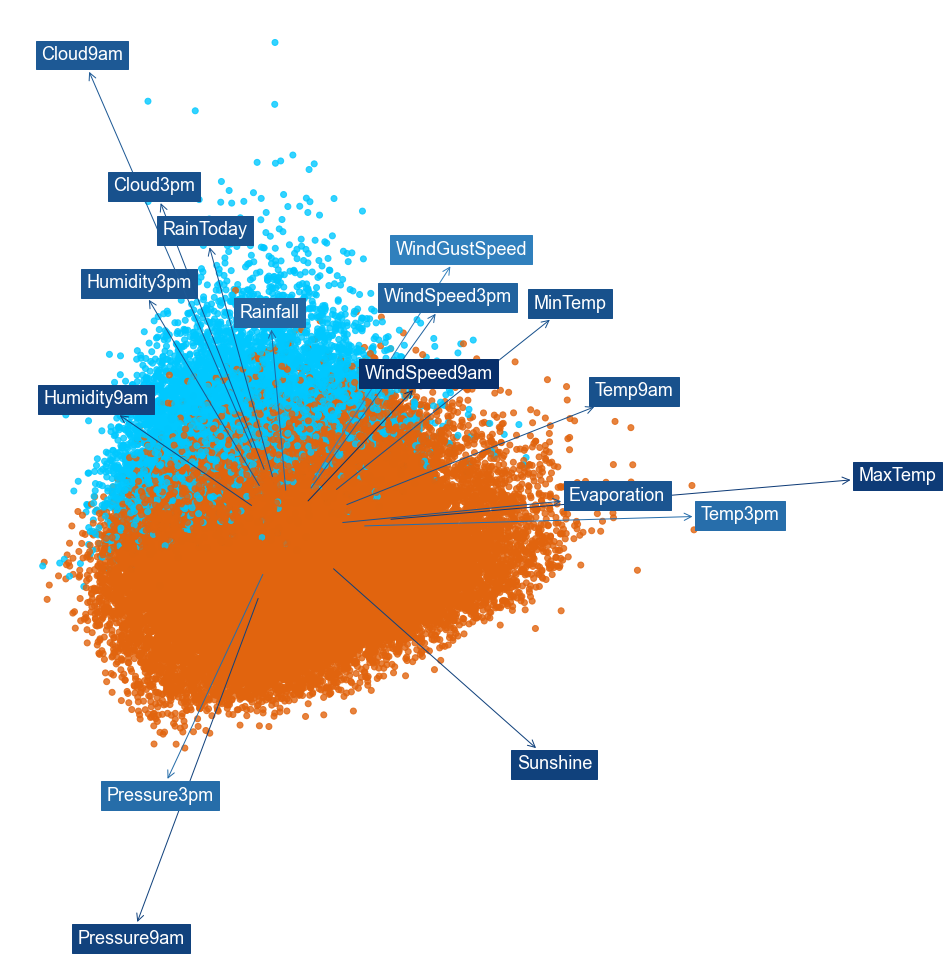

In [8]:
# PCA
# Prepare plot
_, ax = plt.subplots(figsize=(14, 14))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_facecolor('white')
ax.grid(False)

Xs, _, ys, _  = sample_tts(drop=[c for c, _, _ in cat_rng])
feat = Xs.columns # before we lost them into scaling and pca...
Xs = StandardScaler().fit_transform(Xs)

ys = LogisticRegression().fit(Xs, ys).predict(Xs)
pca = PCA(2)
Xs = pca.fit_transform(Xs)

# Plot predictions (re-scale to match pca coef. range)
x = Xs[:,0] * 1. / np.ptp(Xs[:,0]) / 1.2
y = Xs[:,1] * 1. / np.ptp(Xs[:,1]) / 1.2
ax.scatter(x, y, c=np.where(ys == 1, "#00C8FF", "#E1640E"), alpha=.8)

# Compile x, y & mag for annotations
coef = pca.components_
coef = np.array([coef[0,], coef[1,], np.linalg.norm(coef, axis=0)]).T

# Attempt to prevent overlaping text boxes
for i in range(coef.shape[0]):
    a = coef[i]
    for j in range(i):
        b = coef[j]
        if np.linalg.norm(a[:-1] - b[:-1]) < 0.1:
            t = i if a[2] > b[2] else j
            coef[t,:-1] = coef[t,:-1] * (min(a[2], b[2]) / max(a[2], b[2]) + .4)

# Plots in correct z-order (argsort(|v|))
for i in np.flip(coef[:,2].argsort()):
    x = coef[i, 0]
    y = coef[i, 1] # TODO: check corr. colors (color=colors[i])
    plt.annotate(feat[i], xy=(x/6, y/6), xytext=(x, y), color='w', fontsize=18,
                 bbox=dict(boxstyle="square", color=colors[i], alpha=1),
                 arrowprops=dict(arrowstyle="<-", color=colors[i], linewidth=1));

# TODO: add title & legend
# plt.savefig("./outpout/pca.png")

In [ ]:
# TODO: tester Complement Naive Bayes
# TODO: Voir si mieux de passer par des pipelines plutôt que méthode sample_tts